In [11]:
import gymnasium as gym
from matplotlib import pyplot as plt
import re
import numpy as np
from tqdm.notebook import trange, tqdm
from math import floor

In [12]:
!pip install gymnasium

In [13]:

def row_col_to_seq(row_col, num_cols):
    '''
    Converts row_col to num_cols format

    Args:
        row_col (np.ndarray): Location of shape (1,2)
        num_cols (int): Total number of cols
    Return:
        (np.ndarray): Number format of row and column of shape (1,)
  '''
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols):
    '''
    Converts state number to rol_col format
    Args:
        seq (int): Number format of state
        num_cols (int): Number of columns
    Return:
        (np.ndarray): Array of shape (1,2) as [[row, col]]
    '''
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

In [14]:
def policy_ep(q_values, state, ep):
    num_actions = q_values.shape[1]
    rand_num = np.random.random()
    if rand_num < ep:
        action = np.random.choice(np.arange(num_actions))
    else:
        action = np.argmax(q_values[state,:])

    return action


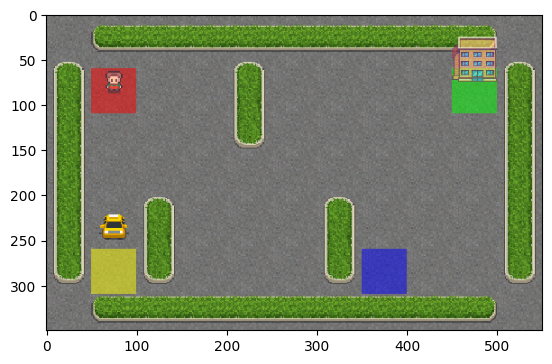

In [15]:
env = gym.make('Taxi-v3', render_mode = 'rgb_array')
s = env.reset()
plt.imshow(env.render())


In [ ]:

# def run_option(state, option, ep, q_vals):
#     opt_terminal_states = {0:[0,0], 1:[0,4], 2:[4,0],3:[4,3]}
#     # Decoding state for row, col, pass_loc, dest_loc
#     taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)
#     # Getting row and col for option terminal loc
#     taxi_target_row, taxi_target_col = opt_terminal_states[option]

#     # Checking if target loc is reached or not
#     if taxi_row == taxi_target_row and taxi_col == taxi_target_col:
#         print(f'Taxi checks: state = {taxi_row}, {taxi_col}, target = {taxi_target_row},{taxi_target_col}')

#         # Goal point reached
#         optdone = True
#         # check passeger loc
#         if option == pass_loc:
#             action = 4
#         elif option == dest_loc:
#             action = 5
#         else:
#             action = 1 if (option in [0,1]) else 0
#     else:
#         optdone = False
#         # Choosing action
#         action = policy_ep(q_vals[:,:,option], state, ep)

#     return action,optdone

In [16]:

def run_option(state, option, ep, q_vals):
    opt_terminal_states = {0:[0,0], 1:[0,4], 2:[4,0],3:[4,3]}
    # Decoding state for row, col, pass_loc, dest_loc
    taxi_row, taxi_col, pass_loc, dest_loc = env.decode(state)
    state_act_seq = row_col_to_seq(np.array([[taxi_row,taxi_col]]), 5)
    # Getting row and col for option terminal loc
    taxi_target_row, taxi_target_col = opt_terminal_states[option]

    # Checking if target loc is reached or not
    if taxi_row == taxi_target_row and taxi_col == taxi_target_col:
        #print(f'Taxi checks: state = {taxi_row}, {taxi_col}, target = {taxi_target_row},{taxi_target_col}')

        # Goal point reached
        optdone = True
        # check passeger loc
        if option == pass_loc:
            action = 4
        elif option == dest_loc:
            action = 5
        else:
            action = 1 if (option in [0,1]) else 0
    else:
        optdone = False
        # Choosing action
        action = policy_ep(q_vals[:,:,option], state_act_seq, ep)

    return action,optdone

In [17]:
row = 5
col = 5
num_pass_loc = 5
num_dest_loc = 4
num_options = 4 # Goto R, G, Y, B
num_primitive_act = 6
num_states = 500
tot_actions = num_primitive_act + num_options

#SMDP

In [39]:
gamma = 0.99
alpha = 0.5
ep = 0.01
# ep_max = 0.5
# ep_min = 0.01
# decay = 0.99
#ep_opt = np.ones(4)*ep_max

num_episodes = 5000
opt_terminal_states = {0:[0,0], 1:[0,4], 2:[4,0],3:[4,3]}
q_val_opt = np.zeros((num_pass_loc*num_dest_loc, num_options)) # shape= (20,4)
update_opt = np.zeros((num_pass_loc*num_dest_loc, num_options))
q_val_actions = np.zeros((row*col, num_primitive_act, num_options)) # shape (25,6,4)
average_reward = 0

for i in tqdm(range(num_episodes)):
    curr_state = env.reset()[0]
    #taxi_start_row, taxi_start_col, pass_loc, dest_idx = env.decode(curr_state)
    done = False
    steps = 0
    tot_reward = 0

    while not done:
        # Decoding state
        taxi_row, taxi_col, pass_loc, dest_idx = env.decode(curr_state)
        curr_opt_seq = row_col_to_seq(np.array([[pass_loc, dest_idx]]), num_dest_loc)

        # choose option
        option = policy_ep(q_val_opt, curr_opt_seq, ep)

        optdone = False
        reward_bar = 0
        opt_start_state = curr_opt_seq
        k = 0

        while not optdone:
            opt_action,optdone = run_option(state = curr_state,
                                            option = option,
                                            ep = ep,
                                            q_vals = q_val_actions)
            next_state, reward, is_terminal, truncated, t_prob = env.step(opt_action)
            reward_bar = gamma*reward_bar + reward
            tot_reward = tot_reward + reward

            # decode curr, next state
            taxi_curr_row, taxi_curr_col, pass_curr_loc, dest_curr_idx = env.decode(curr_state)
            taxi_next_row, taxi_next_col, pass_next_loc, dest_next_idx = env.decode(next_state)
            curr_act_seq = row_col_to_seq(np.array([[taxi_curr_row,taxi_curr_col]]), 5)
            next_act_seq = row_col_to_seq(np.array([[taxi_next_row,taxi_next_col]]), 5)

            q_val_actions[curr_act_seq,opt_action,option] = q_val_actions[curr_act_seq,opt_action,option] + alpha * (reward + gamma * np.max(q_val_actions[next_act_seq,:,option]) - q_val_actions[curr_act_seq,opt_action,option])

            if is_terminal:
                done = True
            if optdone:
                opt_terminal_state = next_state
            k += 1
            steps += 1
            curr_state = next_state
            #ep_opt[option] = ep_min #max(ep_min,decay*ep_opt[option])

        #decode and encode option start and end
        opt_start_row, opt_start_col, pass_start_loc, dest_start_idx = env.decode(opt_start_state)
        opt_end_row, opt_end_col, pass_end_loc, dest_end_idx = env.decode(opt_terminal_state)
        curr_opt_seq = row_col_to_seq(np.array([[pass_start_loc,dest_start_idx]]), 4)
        end_opt_seq = row_col_to_seq(np.array([[pass_end_loc,dest_end_idx]]), 4)
        q_val_opt[curr_opt_seq, option] = q_val_opt[curr_opt_seq, option] + alpha * (reward_bar + (gamma**k)*np.max(q_val_opt[end_opt_seq]) - q_val_opt[curr_opt_seq, option])
        update_opt[curr_opt_seq,option] += 1
    average_reward += 0.0002*tot_reward
    print(f'ep = {i}, steps = {steps}, total reward = {tot_reward},')
print(f'average reward = {average_reward}')


  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


Streaming output truncated to the last 5000 lines.
ep = 1, steps = 366, total reward = -372,
ep = 2, steps = 63, total reward = -42,
ep = 3, steps = 418, total reward = -424,
ep = 4, steps = 10, total reward = 11,
ep = 5, steps = 182, total reward = -206,
ep = 6, steps = 175, total reward = -172,
ep = 7, steps = 133, total reward = -121,
ep = 8, steps = 73, total reward = -52,
ep = 9, steps = 51, total reward = -48,
ep = 10, steps = 23, total reward = -2,
ep = 11, steps = 186, total reward = -201,
ep = 12, steps = 309, total reward = -378,
ep = 13, steps = 36, total reward = -24,
ep = 14, steps = 13, total reward = 8,
ep = 15, steps = 32, total reward = -11,
ep = 16, steps = 49, total reward = -55,
ep = 17, steps = 14, total reward = 7,
ep = 18, steps = 32, total reward = -29,
ep = 19, steps = 52, total reward = -58,
ep = 20, steps = 12, total reward = 9,
ep = 21, steps = 21, total reward = 0,
ep = 22, steps = 12, total reward = 9,
ep = 23, steps = 22, total reward = -1,
ep = 24, steps

#Intra-Option Q-learning

In [81]:
def Intra_options():
  gamma = 0.99
  alpha = 0.5
  eps_main = 0.1

  eps_min = 0.001
  eps_decay = 0.9
  eps_opt = np.ones(4)*eps_main

  rewards_tot = []
  num_episodes = 5000
  opt_terminal_states = {0:[0,0], 1:[0,4], 2:[4,0],3:[4,3]}
  q_val_opt = np.zeros((num_pass_loc*num_dest_loc, num_options)) # shape= (20,4)
  update_val_opt = np.zeros((num_pass_loc*num_dest_loc, num_options))
  q_val_actions = np.zeros((row*col, num_primitive_act, num_options)) # shape (25,6,4)
  avg_tot_rew = 0
  max_rew = 0
  for i in tqdm(range(num_episodes)):
      curr_state = env.reset()[0]
      #taxi_start_row, taxi_start_col, pass_loc, dest_idx = env.decode(curr_state)
      done = False
      steps = 0
      tot_reward = 0

      while not done:
          # Decoding state
          taxi_row, taxi_col, pass_loc, dest_idx = env.decode(curr_state)
          curr_opt_seq = row_col_to_seq(np.array([[pass_loc, dest_idx]]), num_dest_loc)
          eps_main = max(eps_min,eps_main*eps_decay)

          # choose option
          option = policy_ep(q_val_opt, curr_opt_seq, eps_main)

          optdone = False
          reward_bar = 0
          opt_start_state = curr_opt_seq
          k = 0

          while not optdone:
              opt_action,optdone = run_option(state = curr_state,
                                              option = option,
                                              ep = eps_opt[option],
                                              q_vals = q_val_actions)
              next_state, reward, is_terminal, truncated, t_prob = env.step(opt_action)
              tot_reward = tot_reward + reward
              eps_opt[option] = max(eps_min,eps_decay*eps_opt[option])
              # decode curr, next state
              taxi_curr_row, taxi_curr_col, pass_curr_loc, dest_curr_idx = env.decode(curr_state)
              taxi_next_row, taxi_next_col, pass_next_loc, dest_next_idx = env.decode(next_state)
              curr_act_seq = row_col_to_seq(np.array([[taxi_curr_row,taxi_curr_col]]), 5)
              next_act_seq = row_col_to_seq(np.array([[taxi_next_row,taxi_next_col]]), 5)
              q_val_actions[curr_act_seq,opt_action,option] = q_val_actions[curr_act_seq,opt_action,option] + alpha * (reward + gamma * (q_val_actions[next_act_seq,opt_action,option]) - q_val_actions[curr_act_seq,opt_action,option])

              for ot in range(num_options):

                  opt_action_,optdone_ = run_option(state = curr_state,
                                              option = ot,
                                              ep = eps_opt[ot],
                                              q_vals = q_val_actions)

                  if ot !=option:
                    if opt_action_ == opt_action:
                      eps_opt[ot] = max(eps_min,eps_decay*eps_opt[ot])
                      next_state, reward, is_terminal, truncated, t_prob_ = env.step(opt_action)
                      q_val_actions[curr_act_seq,opt_action,ot] = q_val_actions[curr_act_seq,opt_action,ot] + alpha * (reward + gamma * (q_val_actions[next_act_seq,opt_action,ot]) - q_val_actions[next_act_seq,opt_action,ot])
                      curr_state = next_state

              steps += 1
              curr_state = next_state

              if is_terminal:
                  done = True
              if optdone:
                  opt_terminal_state = next_state


              #ep_opt[option] = ep_min #max(ep_min,decay*ep_opt[option])

          #decode and encode option start and end
          opt_start_row, opt_start_col, pass_start_loc, dest_start_idx = env.decode(opt_start_state)
          opt_end_row, opt_end_col, pass_end_loc, dest_end_idx = env.decode(opt_terminal_state)
          curr_opt_seq = row_col_to_seq(np.array([[pass_start_loc,dest_start_idx]]), 4)
          end_opt_seq = row_col_to_seq(np.array([[pass_end_loc,dest_end_idx]]), 4)
          q_val_opt[curr_opt_seq, option] = q_val_opt[curr_opt_seq, option] + alpha * (reward + gamma*np.max(q_val_opt[end_opt_seq]) - q_val_opt[curr_opt_seq, option])
          update_val_opt[curr_opt_seq,option] += 1
          if max_rew < tot_reward:
            max_rew = tot_reward
            q_val_act_max = q_val_actions
      avg_tot_rew += 0.0002*tot_reward
      rewards_tot.append(tot_reward)
      print(f'ep = {i}, steps = {steps}, total reward = {tot_reward},')

  print(f'average total reward = {avg_tot_rew}')
  return rewards_tot

In [82]:
reward_tots = []
for _ in tqdm(range(1)):
  reward_tots.append(Intra_options())
rewards_tot = np.mean(reward_tots,axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


Streaming output truncated to the last 5000 lines.
ep = 1, steps = 67, total reward = -127,
ep = 2, steps = 423, total reward = -861,
ep = 3, steps = 250, total reward = -463,
ep = 4, steps = 294, total reward = -363,
ep = 5, steps = 61, total reward = -40,
ep = 6, steps = 199, total reward = -187,
ep = 7, steps = 204, total reward = -201,
ep = 8, steps = 276, total reward = -345,
ep = 9, steps = 1642, total reward = -2602,
ep = 10, steps = 208, total reward = -250,
ep = 11, steps = 111, total reward = -180,
ep = 12, steps = 132, total reward = -192,
ep = 13, steps = 33, total reward = -48,
ep = 14, steps = 41, total reward = -56,
ep = 15, steps = 16, total reward = -13,
ep = 16, steps = 113, total reward = -164,
ep = 17, steps = 131, total reward = -254,
ep = 18, steps = 27, total reward = -24,
ep = 19, steps = 82, total reward = -55,
ep = 20, steps = 88, total reward = -94,
ep = 21, steps = 117, total reward = -114,
ep = 22, steps = 35, total reward = -32,
ep = 23, steps = 21, total 

Text(0, 0.5, 'Reward')

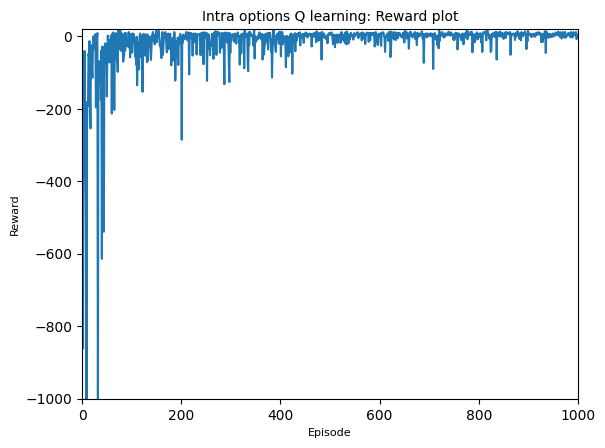

In [89]:
mean_rew = np.mean(reward_tots, axis = 0)
se_rew = np.std(reward_tots, axis = 0)
plt.plot(mean_rew)
plt.fill_between(np.arange(5000),
                 mean_rew - se_rew,
                 mean_rew + se_rew,
                 alpha = 0.5)
plt.ylim(-1000,20)
plt.xlim(0,1000)
plt.title('Intra options Q learning: Reward plot', fontsize = 10)
plt.xlabel('Episode', fontsize = 8)
plt.ylabel('Reward', fontsize = 8)

In [65]:
import pickle
with open('Reward_IOQL.pkl','wb') as f:
     pickle.dump(reward_tots, f)

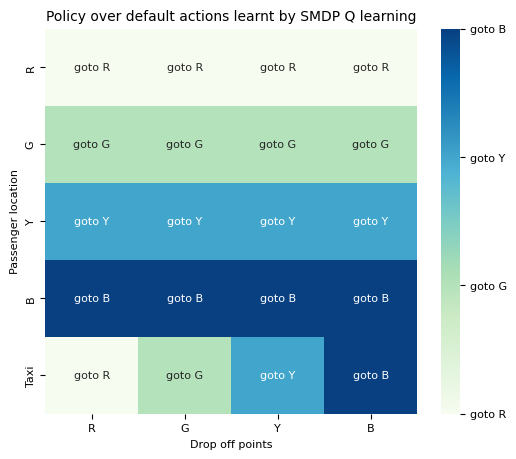

In [84]:
import seaborn as sns

Qmax_SMDP = np.argmax(q_val_opt,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)

figure, axis = plt.subplots(1, 1,figsize=(6,5))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text, fmt = '', cmap = 'GnBu', annot_kws={"size":8})
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])

c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
c_bar.ax.tick_params(labelsize= 8)
#c_bar.set_ticklabels(['south','north','east','west','pick up','drop'])
axis.set_xlabel('Drop off points', fontsize = 8)
axis.set_ylabel("Passenger location",fontsize = 8)
axis.set_title('Policy over default actions learnt by SMDP Q learning', fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

In [85]:
DOWN = 0
UP = 1
LEFT = 3
RIGHT = 2
PICKUP = 4
DROP = 5

def plot_Q(Q, message = "Q plot"):

    fig = plt.figure(figsize=(6,5))
    plt.title(message, fontsize = 10)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2,  cmap = 'GnBu')
    c_bar = plt.colorbar()
    c_bar.ax.tick_params(labelsize= 8)
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        if a in [PICKUP, DROP]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        if a in [PICKUP, DROP]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    #plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

In [28]:
q_val_act_max, max_rew

(array([[[ 0.00000000e+00, -5.21773656e+01, -9.37735922e+01,
          -5.81890713e+01],
         [-9.38355267e+01, -5.28699338e+01, -9.02606323e+01,
          -5.82144871e+01],
         [ 0.00000000e+00, -5.43101963e+01, -9.01011269e+01,
          -5.71376087e+01],
         [ 0.00000000e+00, -5.25854465e+01, -9.02606323e+01,
          -5.82144871e+01],
         [-9.99698148e+01, -5.27219817e+01, -9.37730725e+01,
          -5.84056498e+01],
         [ 1.99893111e+03, -5.88152835e+01, -9.07313472e+01,
          -6.17207228e+01]],
 
        [[-1.52375836e+01, -5.61387046e+01, -8.95406535e+01,
          -4.02155964e+01],
         [-1.29263317e+01, -6.79353391e+01, -8.99025327e+01,
          -5.64166061e+01],
         [-1.34487737e+01, -6.79353391e+01, -8.99025327e+01,
          -5.64166061e+01],
         [-1.00000000e+00, -6.78140131e+01, -8.98887280e+01,
          -5.70443509e+01],
         [-1.78922160e+01, -6.96708846e+01, -9.17986349e+01,
          -5.84056498e+01],
         [-1.78922

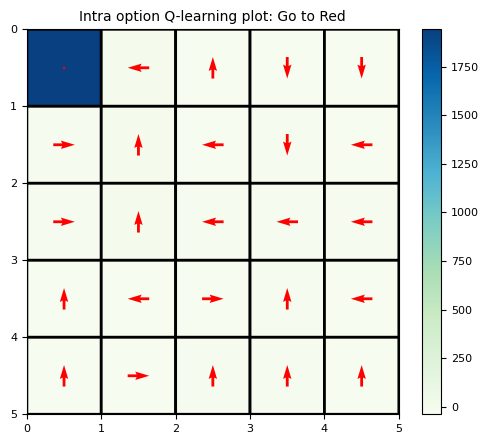

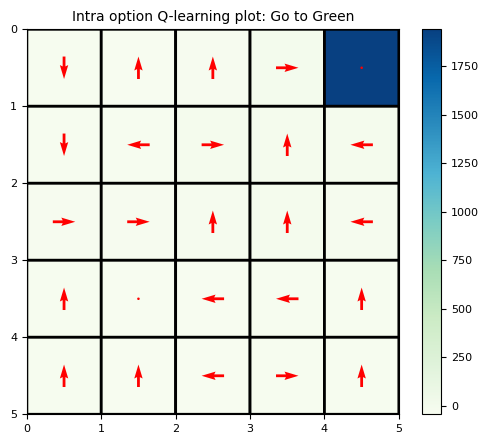

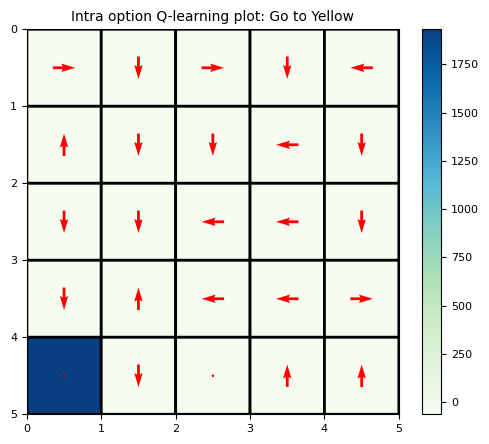

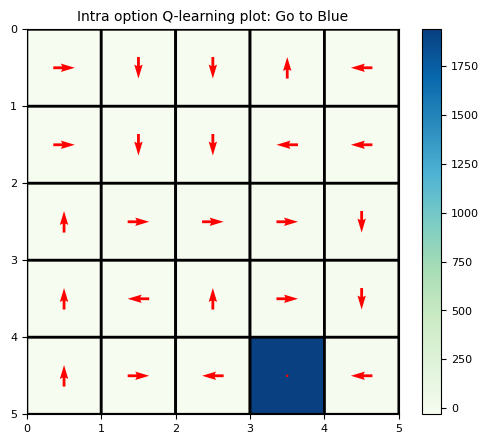

In [86]:
dict_opt = {0:'Red',1:'Green',2:'Yellow',3:'Blue'}
for i in range(4):
  Q_v = q_val_actions[:,:,i]
  Q_v = np.reshape(Q_v,(5,5,6))
  plot_Q(Q_v,message=f'Intra option Q-learning plot: Go to {dict_opt[i]}')

In [ ]:
row_col_to_seq(np.array([[0,0]]),5)

array([0])

In [ ]:
Qopt = {i:np.zeros((500//20,6-2)) for i in range(4)} #Q-values for each option

In [ ]:
Qopt.keys()

dict_keys([0, 1, 2, 3])

In [ ]:
Qopt[0].shape

(25, 4)